In [34]:
from pathlib import Path

import numpy as np
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.datasets.images import Pix2PixDataset
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.style_transfer.models import (Pix2PixDiscriminator,
                                             Pix2PixDiscriminatorLoss,
                                             Pix2PixGenerator,
                                             Pix2PixGeneratorLoss)
from torchvision import transforms
from tqdm import tqdm

# setting

In [35]:
artifacts_path = Path('../../artifacts/pix2pix')
data_path = Path('../../data/edges2shoes/train/*.jpg')

In [36]:
device = torch.device('cuda:0')

In [37]:
BATCH_SIZE = 4
IMAGE_SIZE = 256

# dataset

In [38]:
preprocess = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE * 2)),
        transforms.ToTensor(),
    ]
)

In [39]:
dataset = Pix2PixDataset(data_path.as_posix(), preprocess)

In [40]:
dataset[0][0].shape

torch.Size([3, 256, 256])

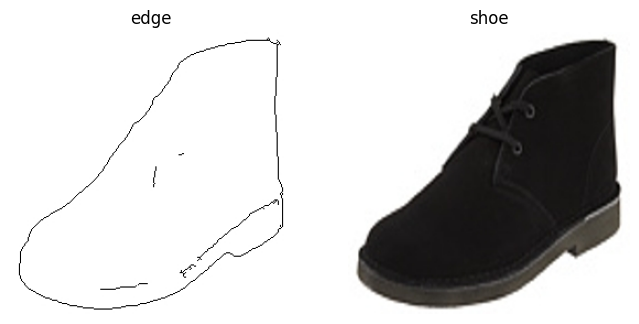

In [41]:
contents, style = dataset[0]

plot_grids(
    [img_tensor_to_np(contents), img_tensor_to_np(style)],
    ['edge', 'shoe'],
    1, 
    2,
)

In [42]:
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

# model

In [43]:
model = Pix2PixGenerator(3).to(device)
discriminator = Pix2PixDiscriminator().to(device)

In [44]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Pix2PixGenerator                         --
├─DownSampling: 1-1                      --
│    └─Sequential: 2-1                   --
│    │    └─ConvBnRelu: 3-1              1,856
│    │    └─ConvBnRelu: 3-2              36,992
│    │    └─MaxPool2d: 3-3               --
├─DownSampling: 1-2                      --
│    └─Sequential: 2-2                   --
│    │    └─ConvBnRelu: 3-4              73,984
│    │    └─ConvBnRelu: 3-5              147,712
│    │    └─MaxPool2d: 3-6               --
├─DownSampling: 1-3                      --
│    └─Sequential: 2-3                   --
│    │    └─ConvBnRelu: 3-7              295,424
│    │    └─ConvBnRelu: 3-8              590,336
│    │    └─MaxPool2d: 3-9               --
├─DownSampling: 1-4                      --
│    └─Sequential: 2-4                   --
│    │    └─ConvBnRelu: 3-10             1,180,672
│    │    └─ConvBnRelu: 3-11             2,360,320
│    │    └─MaxPool2d: 3-12    

In [45]:
torchinfo.summary(discriminator)

Layer (type:depth-idx)                   Param #
Pix2PixDiscriminator                     --
├─Sequential: 1-1                        --
│    └─ConvInLRelu: 2-1                  --
│    │    └─Sequential: 3-1              1,760
│    └─ConvInLRelu: 2-2                  --
│    │    └─Sequential: 3-2              18,496
│    └─ConvInLRelu: 2-3                  --
│    │    └─Sequential: 3-3              73,856
│    └─ZeroPad2d: 2-4                    --
│    └─Conv2d: 2-5                       1,153
Total params: 95,265
Trainable params: 95,265
Non-trainable params: 0

# train

In [46]:
LR = 1e-4
BETA = (0.5, 0.999)
EPOCHES = 3

In [47]:
LAMBDA = 1e2

In [48]:
criterion_G = Pix2PixGeneratorLoss(LAMBDA)
criterion_D = Pix2PixDiscriminatorLoss()
optim_G = torch.optim.Adam(model.parameters(), lr=LR, betas=BETA)
optim_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=BETA)

In [ ]:
model.train()
discriminator.train()
for e in range(EPOCHES):
    running_loss_G = 0.0
    running_loss_D = 0.0

    for real_img, real_label in tqdm(dataloader):
        real_img = real_img.to(device)
        real_label = real_label.to(device)

        # train G
        optim_G.zero_grad()

        generated = model(real_img)
        loss_G = criterion_G(
            discriminator(generated, real_img),
            generated,
            real_label,
        )
        loss_G.backward()

        optim_G.step()
        running_loss_G += loss_G.item()

        # train D
        optim_D.zero_grad()

        loss_D = criterion_D(
            discriminator(real_label, real_img),
            discriminator(generated.detach(), real_img),
        )
        loss_D.backward()

        optim_D.step()
        running_loss_D += loss_D.item()

    print(
        f"epoch {e+1}:",
        f"D:{running_loss_D / len(dataset)}",
        f"G:{running_loss_G / len(dataset)}",
    )

In [56]:
model_path = artifacts_path.joinpath('edge2shoe.pth').as_posix()

In [57]:
torch.save(model.state_dict(), model_path)

In [ ]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# inference

In [68]:
test_data_path = Path('../../data/edges2shoes/val/*.jpg')

In [70]:
test_dataset = Pix2PixDataset(test_data_path.as_posix(), preprocess)

In [71]:
with torch.no_grad():
    model.eval()
    contents = torch.stack([test_dataset[i][0] for i in range(9)]).to(device)
    styles = torch.stack([test_dataset[i][1] for i in range(9)]).to(device)
    output = img_tensor_to_np(model(contents)).clip(0, 1)

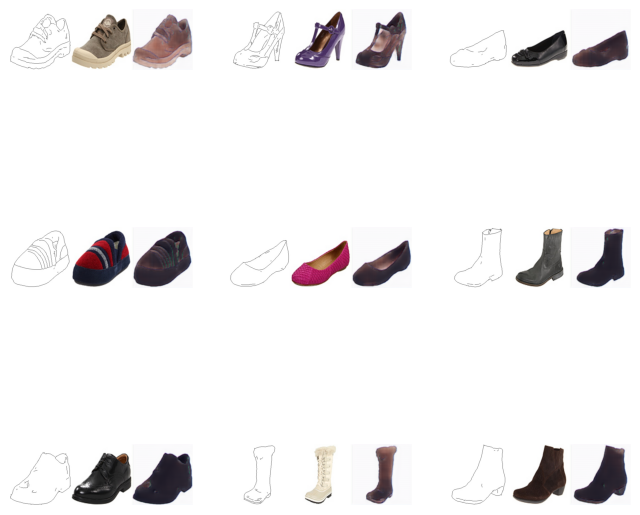

In [72]:
plot_grids(
    np.concatenate(
        [img_tensor_to_np(contents), img_tensor_to_np(styles), output],
        axis=2,
    ),
    num_row=3,
    num_col=3,
)